In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import np_utils
from keras.callbacks import TensorBoard
from keras import regularizers

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


# Let's train a hand-written digit classifier

We will use the famous handwritten digit dataset MNIST.  This is a very popular data set for training small networks, since the data typically fits in local memory, and you can do convolutional networks with it.  This time, though, we will not be doing convolutional networks.  We will just be training a "multi-layer perceptron" or a "fully-connected network", keeping this as simple as possible to highlight how easy it is to use Keras.  We'll take each step in turn:
- Data
- Loss
- Optimizer
- Model
- Callbacks
- (Regularization)


# Data
MNIST is so famous it comes packaged with keras.  Let's take a look

In [2]:
(train_feats, train_labels), (valid_feats, valid_labels) = mnist.load_data()
train_feats.shape

(60000, 28, 28)

Ok, so in our training set we have 60k handwritten digits.  Each digit is an image of size 28 x 28.  Let's look at one of the images just to see what we're dealing with

In [3]:
train_feats[558][10:20, 10:20] # this is just a slice of the middle

array([[ 42,  54, 213, 241,  95,   0,   0,   0,   0,   0],
       [  0,   0,  93, 254, 115,   0,   0,   0,   0,   0],
       [  0,   0,  93, 255, 115,   0,   0,   0,   0,   0],
       [  0,   0, 176, 254, 115,   0,   0,   0,   0,   0],
       [  0,  28, 215, 254, 115,   0,   0,   0,   0,   0],
       [134, 240, 253, 228,  40,   0,   0,   0,   0,   0],
       [206, 254, 254,  68,   0,   0,   0,   0,   0,   0],
       [ 29, 211, 253, 147,  21,   0,   0,   0,   0,   0],
       [  0,  21, 180, 245, 228, 165, 116, 116, 116, 116],
       [  0,   0,   0,  44, 119, 202, 253, 254, 253, 253]], dtype=uint8)

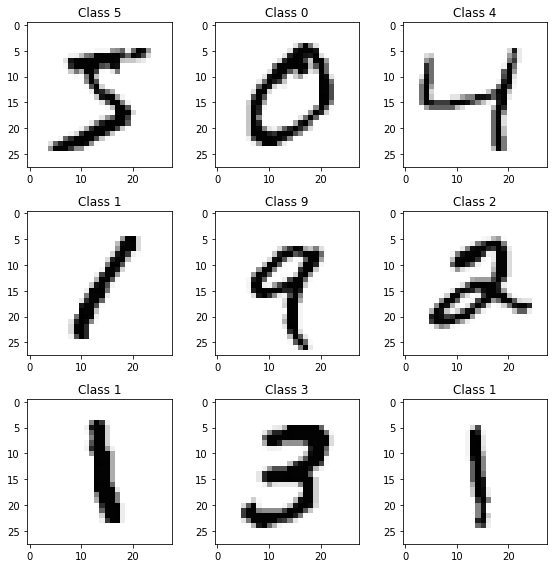

In [4]:
# this is what we get if we plot the data with the pixel densities
fig = plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(train_feats[i], cmap='Greys', interpolation='none')
    plt.title("Class {}".format(train_labels[i]))
plt.tight_layout()

Handwritten digits are inherently 2-D, in that they have regular two-dimensional structure.  To better deal with that structure, we'll use Convolutional networks later, but for now what we'll do is just treat every pixel as if it is its own feature, and ask the question, can a neural network learn the complicated relationships that exist between individual pixel locations?  

So we'll flatten all the features so each number is a one-dimensional vector of length 784

In [5]:
train_feats = train_feats.reshape(60000, 784)
valid_feats = valid_feats.reshape(10000, 784)

Now let's look at the labels

In [6]:
train_labels[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

The labels are integers corresponding to the actual digits.  We will need to one-hot-encode them.  (ie make them categorical, or dummy variables)

In [7]:
# now let's make the labels categorical
train_labels = pd.get_dummies(train_labels)
valid_labels = pd.get_dummies(valid_labels)

In [8]:
train_labels.head(5)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1


One more thing is we should probably normalize the data.  For now lets just scale it to between 0 and 1 by dividing by the max value (255)

In [9]:
train_feats = train_feats / 255
valid_feats = valid_feats / 255

We could think about normalizing instead of just scaling, but let's call it good for now

# Loss

Since we are classifying each example as one of many different classes (digits), we will be attempting to minimize the categorical crossentropy function described in the lecture notes.  We'll see later how to make custom loss functions, but for now since we are using a common loss, we can just use the string identifier

In [10]:
loss = 'categorical_crossentropy'

# Optimizer
We'll use the common optimizer "Adam" as described in the lectures.  Again, since it is a very common optimizer, we can just use the string identifier and Keras will initialize the Adam optimizer with default parameters when we compile

In [11]:
opt = 'adam'

# Model (activations)

Great!  We're now ready to build, compile, and fit our Keras model.  We'll use the Keras functional API since we are not savages

Our model will consist of an input layer, two Dense Layers, and a 10-dimensional output layer for predicting the digits.  For each layer we will consider what sort of activation functions to use.  For the hidden layers we'll use the reLU activation, which is fairly standard default at the moment.  The final activation layer will be a softmax

In [12]:
inputs = Input(shape=(784,)) # Indicates batches of 784-dimensional vectors
x = Dense(256, activation='relu')(inputs)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

Now we compile the model, telling it which optimizer and loss to use.  
We'll also tell it to calculate accuracy at every epoch

Then we'll print out a handy keras summary

In [13]:
model.compile(optimizer=opt,
             loss=loss, 
             metrics=['accuracy'])

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________


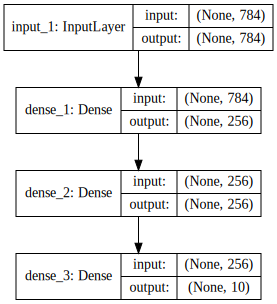

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))
# Note: input: shape is (None, 784) because the batch size is unknown. Shape fed to model is (batchsize, 784)

Now we'll fit the model.  The things we need to give the fit function are: Training data, the number of epochs to run, and the batch size.  

**epochs** An epoch is a somewhat arbitrary division of training, but for small closed data sets usually an epoch is an entire run through the training data.  You can specify smaller epochs

Optionally we can also give it validation data, and it will calculate metrics on that data set as well

If you want Keras to split the training data for you automatically, you can just pass it the parameter validation_split

In [15]:
n_epochs = 20
history = model.fit(train_feats, train_labels,
         epochs=n_epochs,
         batch_size=64,
         validation_data = (valid_feats, valid_labels),
         verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 139us/step - loss: 0.2199 - acc: 0.9345 - val_loss: 0.1081 - val_acc: 0.9669
Epoch 2/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.0847 - acc: 0.9735 - val_loss: 0.0792 - val_acc: 0.9751
Epoch 3/20
60000/60000 [==============================] - 7s 122us/step - loss: 0.0571 - acc: 0.9822 - val_loss: 0.0787 - val_acc: 0.9740
Epoch 4/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0407 - acc: 0.9871 - val_loss: 0.0747 - val_acc: 0.9778
Epoch 5/20
60000/60000 [==============================] - 8s 126us/step - loss: 0.0325 - acc: 0.9892 - val_loss: 0.0868 - val_acc: 0.9742
Epoch 6/20
60000/60000 [==============================] - 8s 131us/step - loss: 0.0256 - acc: 0.9917 - val_loss: 0.0757 - val_acc: 0.9789
Epoch 7/20
60000/60000 [===

Great! We have some data about the accuracy of the model but just for fun let's make a confusion matrix

In [16]:
valid_pred = np.argmax(model.predict(valid_feats), 1)
valid_labels_dense = np.argmax(valid_labels.values, 1)
confusion_matrix(valid_labels_dense, valid_pred)

array([[ 967,    1,    2,    0,    1,    0,    5,    2,    1,    1],
       [   0, 1128,    2,    0,    0,    0,    1,    1,    3,    0],
       [   3,    1, 1004,    5,    4,    0,    0,    7,    7,    1],
       [   0,    0,    1,  993,    0,    2,    0,    3,    6,    5],
       [   0,    0,    1,    0,  970,    0,    4,    2,    0,    5],
       [   1,    0,    0,    9,    1,  866,    4,    1,   10,    0],
       [   0,    3,    2,    0,    7,    4,  941,    0,    1,    0],
       [   1,    4,    8,    3,    1,    0,    1,  999,    5,    6],
       [   0,    0,    3,    4,    1,    0,    1,    2,  962,    1],
       [   1,    2,    0,    5,    6,    2,    1,    2,    5,  985]])

We can also use the training history and plot it

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


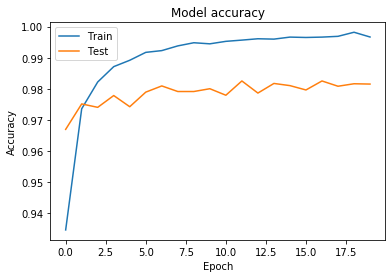

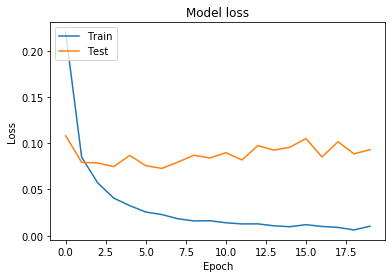

In [17]:
# list all data in history
print(history.history.keys())

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Callbacks

Callbacks are extremely useful in Keras.  They allow you to specify any particular action you want done at periodic intervals, typically at the end of each epoch.  Common options include:

- Checkpoint the model by saving it periodically
- Keep track of the model with the best validation performance
- write to a log.  TENSORBOARD
- Calculate custom metrics that can't be calculated over batches (like auc)


Let's retrain the above model, but using a Tensorboard callback.  We'll also remake the model and add in another metric, 'accuracy', for keras to keep track of and log.

To access tensorboard, run "tensorboard --logdir ..logs/" replacing ..logs/ with whatever you set your log directory to be below

You can also view the tensorboard in a separate notebook
<pre>
%load_ext tensorboard
%tensorboard --logdir ../logs/mnist_model3
</pre>

In [18]:
# change the name of the callback every time you run it so you don't write multiple training runs to the same log
tb_callback = TensorBoard('../mnist_model3')

In [19]:
model.compile(optimizer=opt,
             loss=loss, 
             metrics=['accuracy'])

model.summary()

model.fit(train_feats, train_labels,
         epochs=30,
         batch_size=64,
         validation_data = (valid_feats, valid_labels),
         callbacks=[tb_callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 269,322
Trainable params: 269,322
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples


Epoch 1/30
60000/60000 [==============================] - 8s 130us/step - loss: 0.0101 - acc: 0.9969 - val_loss: 0.1331 - val_acc: 0.9791
Epoch 2/30
60000/60000 [==============================] - 7s 112us/step - loss

# Regularization

Regularization is a huge part of deep learning, and we'll spend A LOT more time talking about it.  You should see that the model we have trained is overfit to the training set. But for now with what we've learned so far, it may be useful to try some regularization.

- **Limiting model capacity.** Models with fewer parameters are less able to overfit.  Limit model capacity, usually by decreasing the number of layers or the number of nodes per layer.
- **Early stopping.** The longer you train, the more likely the model will memorize noise between the training set and the labels.  Monitor validation metrics, and if they start getting bad while the training metrics continue to improve, you may want to stop training there.  In Keras, often "early stopping" is handled by callbacks which can either save models periodically (so you can get the best ones from the past if the model starts overfitting), or by dropping the learning rate progressively to zero as the validation metrics get worse and worse.
- **L1, L2 regularization** Add a penalty for high weights to the loss.  In practice this is less common than it is in simple linear/logistic regression, but it is valid and still used.


In deep learning practice, much of your time will be spent experimenting with regularization strategies

In [20]:
tb_callback = TensorBoard('../logs/mnist_model4')

#initialize an l2 regularization - adds a penalty term to the loss function
l2_reg = regularizers.l2(.001)

inputs = Input(shape=(784,))
# go down to layer size 64.  
# Note what happens to the number of model parameters in the summary

x = Dense(64, activation='relu', kernel_regularizer=l2_reg)(inputs)
x = Dense(64, activation='relu', kernel_regularizer=l2_reg)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer=opt,
             loss=loss, 
             metrics=['accuracy'])

model.summary()

# go down to 20 epochs
model.fit(train_feats, train_labels,
         epochs=20,
         batch_size=64,
         validation_data = (valid_feats, valid_labels),
         callbacks=[tb_callback])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                50240     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 55,050
Trainable params: 55,050
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 6s 103us/step - loss: 0.4681 - acc: 0.9023 - val_loss: 0.2992 - val_acc: 0.9481
Epoch 2/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.2

Examine the loss and validation loss above or in Tensorboard. Is the model less overfit?  Was there enough regularization?  Too much?  Just right?

Loss can be seen as a distance between the true values of the problem and the values predicted by the model. Greater the loss is, more huge is the errors you made on the data.

Accuracy can be seen as the numbers of error you made on the data.

That means :
- a low accuracy and huge loss means you made huge errors on a lot of data
- a low accuracy but low loss means you made little errors on a lot of data
- a great accuracy with low loss means you made low errors on a few data (best case)
- a great accuracy but a huge loss, means you made huge errors on a few data.


NOTE :

Don't forget that low or huge loss is a subjective metric, which depends on the problem and the data. It's a distance between the true value of the prediction, and the prediction made by the model. It depends also on the loss you use.

Think :
- If your data are between 0 and 1, a loss of 0.5 is huge, but if your data are between 0 and 255, an error of 0.5 is low.
- Maybe think of cancer detection, and probability of detecting a cancer. Maybe an error of 0.1 is huge for this problem, whereas an error of 0.1 for image classification is fine.

